# Advanced Examples
In this notebook, a number of advanced examples using BioCRNpyler will be presented. These are desiged to highlight a number of different built-in Mechanisms and Components and how they can be used in an object oriented fashion. For details on how to create your own Mechanisms, Components, and Mixtures, see the Developer Overview Notebook.

## Example 1: Retroactivity and Loading
Most of the default Mixtures in BioCRNpyler include transcription, translation, and degredation machinery such as RNAP (RNA Polymerase), Ribosomes, and RNAases. In the following example, we will illustrate loading effects due to competition over this machinery. For this example, we will use the following model of constituitive transcription and translation:

$G_i + \textrm{RNAP} \leftrightarrow G_i:\textrm{RNAP} \rightarrow G_i + \textrm{RNAP} + T_i$

$T_i + \textrm{Ribosome} \leftrightarrow T_i:\textrm{Ribosome} \rightarrow T_i + \textrm{Ribosome} + P_i$

$T_i + \textrm{RNAase} \leftrightarrow T_i:\textrm{RNAase} \rightarrow \textrm{RNAase}$

Here $G_i$, $T_i$ and $P_i$ are gene, transcript, and protein $i$, respectively. In the example that follows, we will allow different RNA polymerases for different genes. Also, some genes may not be translated at all. By using orthogonal polymerases and/or loads without translation, we will see different kinds of loading effects.

We will create 4 different DNA assemblies. The reference assembly, "ref", will have a RNAP promoter and an RBS. We will examine the output of this reporter as a function of the amount of various load assemblies.
* The "Load" assembly will be identical to the "ref" assembly; this assembly will put load on all parts of transcription, RNA degredation, and translation for the ref assembly.
* The "TxLoad" assembly will have an RNAP promoter, but no RBS, ensuring that only RNAP and RNAases experience loading, not ribosomes.
* The "T7Load" assembly will have a T7 promoter and an RBS so there will be no loading on polymerases.
* the "T7TxLoad" assmebly will have a T7 promoter and no RBS, so there will only be load on the RNAases.

The creation of these assemblies highlights the flexible, object oriented nature of bioCRNpyler.


Species = complex_protein_RNAP_dna_ref, dna_ref, complex_protein_Ribo_rna_ref, rna_ref, protein_ref, complex_protein_RNAase_rna_ref, complex_rna_Load_protein_Ribo, protein_Load, rna_Load, dna_Load, complex_dna_Load_protein_RNAP, complex_rna_Load_protein_RNAase, protein_T7Load, rna_T7Load, dna_T7Load, complex_protein_Ribo_rna_T7Load, complex_protein_RNAase_rna_T7Load, complex_protein_T7_dna_T7Load, protein_T7, complex_protein_RNAP_dna_TxLoad, rna_TxLoad, complex_protein_RNAase_rna_TxLoad, dna_TxLoad, complex_protein_T7_dna_T7TxLoad, rna_T7TxLoad, complex_protein_RNAase_rna_T7TxLoad, dna_T7TxLoad, protein_RNAP, protein_Ribo, protein_RNAase
Reactions = [
	dna_ref + protein_RNAP <--> complex_protein_RNAP_dna_ref        massaction: k_f(dna_ref,protein_RNAP)=100*dna_ref*protein_RNAP        k_r(complex_protein_RNAP_dna_ref)=10*complex_protein_RNAP_dna_ref
	complex_protein_RNAP_dna_ref --> dna_ref + rna_ref + protein_RNAP        massaction: k_f(complex_protein_RNAP_dna_ref)=3.0*complex_protei

C:\ProgramData\Anaconda3\lib\site-packages\html5lib\_trie\_base.py:3: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Mapping
C:\ProgramData\Anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
C:\ProgramData\Anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


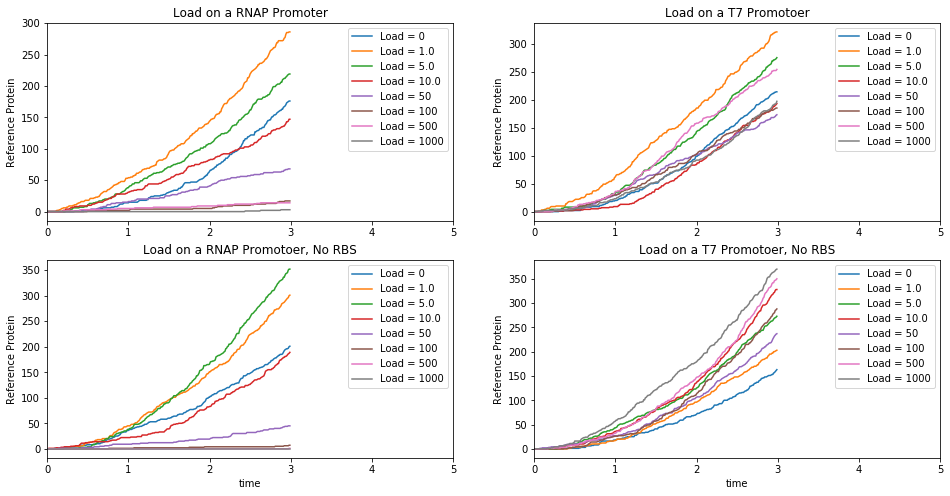

In [1]:
from biocrnpyler import *
%matplotlib inline

#Because we are lazy, all parameters will use the default "param_name"-->value key mapping.
#Parameter warnings will be later suppressed in the Mixture constructor
#For details on how parameter loading and defaulting works, see the Parameter notebook.
kb, ku, ktx, ktl, kdeg = 100, 10, 3.0, 5.0, 2
parameters = {"kb":kb, "ku":ku, "ktx":ktx, "ktl":ktl, "kdeg":kdeg}

#A constituitively expressed reporter
#By default the promoter 'P' will use the polymerase 'rnap'
reference_assembly = DNAassembly(name = "ref", promoter = "P", rbs = "BCD")
#A constiuitively expressed load (RNA and Protein)
full_load_assembly = DNAassembly(name = "Load", promoter = "P", rbs = "BCD")
#A constiutively transcribed (but not translated) load
#By putting rbs = None, DNAassembly automatically knows not to include translation
RNA_load_assembly = DNAassembly(name = "TxLoad", promoter = "P", rbs = None)

#Load genes on orthogonal polymerases
T7 = Protein("T7") #Create a new protein (polymerase) called 'T7'

#Create a custom promoter with a custom mechanism that uses T7 instead of RNAP
#instantiate a new mechanism Transcription_MM with its own name and overwrote the default parameter rnap
mechanism_txt7 = Transcription_MM(name = "T7_transcription_mm", rnap=T7)
#Create an instance of a promoter with this mechanism for transcription
T7P = Promoter("T7P", mechanisms={"transcription":mechanism_txt7})
#Create A load assembly with the custom T7 promoter
T7_load_assembly = DNAassembly(name = "T7Load", promoter = T7P, rbs = "BCD")

#Each new assembly requires its own promoter instance - so here I create another here
T7P = Promoter("T7P", mechanisms={
    "transcription":Transcription_MM(name = "T7_transcription_mm", rnap=T7)})
#A load assembly with the custom T7 promoter and no RBS
T7RNA_load_assembly = DNAassembly(name = "T7TxLoad", promoter = T7P, rbs = None)

#Add all the assemblies to a mixture
components = [reference_assembly, full_load_assembly, T7_load_assembly, T7, RNA_load_assembly, T7RNA_load_assembly]
myMixture = BasicExtract(name = "txtl", parameters = parameters, components = components, parameter_warnings = False)

#Print the CRN
myCRN = myMixture.compile_crn()
print("\n"+repr(myCRN)+"\n")


#Simulate with BioSCRAPE if installed
try:
    print("Simulating")
    import numpy as np
    import pylab as plt
    timepoints = np.arange(0, 3, .01)
    stochastic = True #Whether to use ODE models or Stochastic SSA models
    plt.figure(figsize = (16, 8))
    plt.subplot(221)
    plt.title("Load on a RNAP Promoter")
    loads = [0, 1.0, 5., 10., 50, 100, 500, 1000]
    for dna_Load in loads:
        #print("Simulating for dna_Load=", dna_Load)
        x0_dict = {"protein_T7": 10., "protein_RNAP":10., "protein_RNAase":5.0, "protein_Ribo":50.,
                   'dna_ref':5., 'dna_Load':dna_Load}

        results = myCRN.simulate_with_bioscrape(timepoints, x0_dict, stochastic = stochastic)
        plt.plot(timepoints, results["protein_ref"], label = "Load = "+str(dna_Load))

    plt.xlim(0, 5)
    #plt.xlabel("time")
    plt.ylabel("Reference Protein")
    plt.legend()

    plt.subplot(222)
    plt.title("Load on a T7 Promotoer")
    for dna_Load in loads:
        #print("Simulating for dna_T7Load=", dna_Load)
        x0_dict = {"protein_T7": 10., "protein_RNAP":10., "protein_RNAase":5.0, "protein_Ribo":50.,
                   'dna_ref':5., 'dna_T7Load':dna_Load}
        results = myCRN.simulate_with_bioscrape(timepoints, x0_dict, stochastic = stochastic)
        plt.plot(timepoints, results["protein_ref"], label="Load = " + str(dna_Load))
    plt.xlim(0, 5)
    #plt.xlabel("time")
    plt.ylabel("Reference Protein")
    plt.legend()

    plt.subplot(223)
    plt.title("Load on a RNAP Promotoer, No RBS")
    for dna_Load in loads:
        #print("Simulating for dna_TxLoad=", dna_Load)
        x0_dict = {"protein_T7": 10., "protein_RNAP":10., "protein_RNAase":5.0, "protein_Ribo":50.,
                   'dna_ref':5., 'dna_TxLoad':dna_Load}
        results = myCRN.simulate_with_bioscrape(timepoints, x0_dict, stochastic = stochastic)
        plt.plot(timepoints, results["protein_ref"], label="Load = " + str(dna_Load))
    plt.xlim(0, 5)
    plt.xlabel("time")
    plt.ylabel("Reference Protein")
    plt.legend()

    plt.subplot(224)
    plt.title("Load on a T7 Promotoer, No RBS")
    for dna_Load in loads:
        #print("Simulating for dna_T7TxLoad=", dna_Load)
        x0_dict = {"protein_T7": 10., "protein_RNAP":10., "protein_RNAase":5.0, "protein_Ribo":50.,
                   'dna_ref':5., 'dna_T7TxLoad':dna_Load}
        results = myCRN.simulate_with_bioscrape(timepoints, x0_dict, stochastic = stochastic)
        plt.plot(timepoints, results["protein_ref"], label="Load = " + str(dna_Load))
    plt.xlim(0, 5)
    plt.xlabel("time")
    plt.ylabel("Reference Protein")
    plt.legend()
    plt.show()
except ModuleNotFoundError:
    pass

## Example 2: Regulated Promoters
In this example we will consider combinatoric promoter regulated with an activator and a repessor. The reaction schema used by the RegulatedPromoter class is:
$P + n_i*R_i \leftrightarrow P:nR_i$ which represents $n_i$ copies of the regulator $R_i$ binding to the promoter $P$ in a single step.
$P:nR_i + rnap \leftrightarrow P:nR:rnap \rightarrow P:n_i*R_i + rnap + T$ which represents the binding of $rnap$ to the promoter-regulator complex and subsequent transcription to produce $T$. Mechalis Menten translation and mRNA degredation as described for a TX-TL extract are also included in this model.

To have both an activator and a repressor, we will allow the promoter 'P_reg' to bind to a regulator 'activator' and a regulator 'repressor'. The RNAP binding rates and the transcription rates for the regulator-promoter complexes will be chosen to give rise to activation and repression.


Species = protein_reporter, complex_protein_Ribo_rna_reporter, rna_reporter, complex_protein_4.0xactivator_dna_reporter, complex_protein_4.0xrepressor_dna_reporter, dna_reporter, complex_protein_RNAP_protein_4.0xactivator_dna_reporter, complex_protein_RNAP_protein_4.0xrepressor_dna_reporter, complex_protein_RNAP_dna_reporter, complex_protein_RNAase_rna_reporter, protein_activator, protein_repressor, protein_RNAP, protein_Ribo, protein_RNAase
Reactions = [
	dna_reporter + protein_RNAP <--> complex_protein_RNAP_dna_reporter        massaction: k_f(dna_reporter,protein_RNAP)=100*dna_reporter*protein_RNAP        k_r(complex_protein_RNAP_dna_reporter)=100*complex_protein_RNAP_dna_reporter
	complex_protein_RNAP_dna_reporter --> dna_reporter + rna_reporter + protein_RNAP        massaction: k_f(complex_protein_RNAP_dna_reporter)=1.0*complex_protein_RNAP_dna_reporter
	4.0*protein_activator + dna_reporter <--> complex_protein_4.0xactivator_dna_reporter        massaction: k_f(protein_activator,dn

C:\ProgramData\Anaconda3\lib\site-packages\biocrnpyler-0.1-py3.7.egg\biocrnpyler\extracts.py:43: UserWarning: Parameter warnings have been set True. Verbose warnings regarding parameter files will be displayed.
C:\ProgramData\Anaconda3\lib\site-packages\biocrnpyler-0.1-py3.7.egg\biocrnpyler\extracts.py:48: UserWarning: Initial concentrations for extract species will all be set to zero.


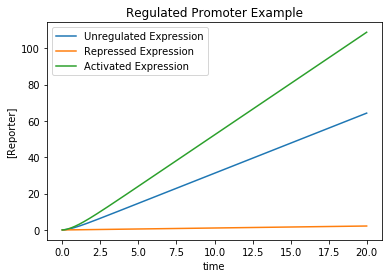

In [2]:
import biocrnpyler as bcp
import numpy as np

#All Necessary Parameters are passed in as a dictionary in the form: (mechanism, part_id, param_name):Val
#These could also be loaded from a file, but are shown here to illustrate the required parameter keys.
parameters = {
    #Promoter Activator Binding Parameters. Note the part_id = [promoter_name]_[regulator_name]
    ('one_step_cooperative_binding', 'P_reg_activator', 'kb'):1000, #Promoter - Activator Binding
    ('one_step_cooperative_binding', "P_reg_activator", 'ku'):5.0, #Unbinding
    ('one_step_cooperative_binding',"P_reg_activator", 'cooperativity'):4.0, #Cooperativity
    
    #Activated Promoter Transcription. Note the part_id = [promoter_name]_[regulator_name]
    #These regulate RNAP binding to an activated promoter and transcription
    ('transcription_mm', 'P_reg_activator', 'kb'): 1000, #Binding to RNAP
    ('transcription_mm', "P_reg_activator", 'ku'): 10.0, #Unbinding
    ('transcription_mm', 'P_reg_activator', "ktx"): 1.25, #Transcription Rate
    
    #Promoter Repressor Binding Parameters. Note the part_id = [promoter_name]_[regulator_name]
    ('one_step_cooperative_binding', 'P_reg_repressor', 'kb'):1000,
    ('one_step_cooperative_binding',"P_reg_repressor", 'ku'):5.0,
    ('one_step_cooperative_binding',"P_reg_repressor", 'cooperativity'):4.0,
    
    #Repressed Promoter Transcription. Note the part_id = [promoter_name]_[regulator_name]
    #These regulate RNAP binding to a repressed promoter and transcription
    ('transcription_mm', 'P_reg_repressor', 'kb'): 10, #Binding to RNAP
    ('transcription_mm', "P_reg_repressor", 'ku'): 1000.0, #Unbinding
    ('transcription_mm', 'P_reg_repressor', "ktx"): .25, #Transcription Rate
    
    #Leak Parameters for transcription
    #These regulate expression of an unbound promoter
    ('transcription_mm', 'P_reg', "kb"): 100, #Binding to RNAP
    ('transcription_mm', 'P_reg', "ku"): 100, #Unbinding
    ('transcription_mm', 'P_reg', "ktx"): 1., #Transcription Rate
              
    #Translation Parameters:
    ('translation_mm', 'BCD', 'kb'): 50, #Binding to Ribosome
    ('translation_mm', 'BCD', 'ku'): 10.0, #Unbinding
    ('translation_mm', 'BCD', 'ktl'): 2.0, #Translation Rate
    
    #RNA Degredation Parameters
    ("rna_degredation_mm", "kb"): 500, #RNAase-RNA binding (Default for RNA Degredation)
    ("rna_degredation_mm", "ku"): 1.0, #RNAase-RNA unbinding (Default for RNA Degredation)
    ("rna_degredation_mm", "kdeg"): 2.5 #Degredation Rate (Default for RNA Degredation)
}
              
#Create a RegulatedPromoter Object named "P_reg" with regulators "activator" and "repressor"
P_reg = bcp.RegulatedPromoter("P_reg", regulators=["activator", "repressor"], leak=True)

#Create a DNA Assembly with an instance of the RegulatedPromoter
reg_rep_assembly = bcp.DNAassembly(name="reporter", promoter=P_reg, rbs="BCD")

#Define the activator and repressor species as proteins
activator = bcp.Protein("activator")
repressor = bcp.Protein("repressor")

#Create a Mixture
components = [reg_rep_assembly, activator, repressor]
myMixture = bcp.BasicExtract(name="txtl", parameters=parameters, components=components, parameter_warnings=True)

myCRN = myMixture.compile_crn()
print("\n"+repr(myCRN))

#Simulate with BioSCRAPE, if installed
try:
    import pylab as plt
    time = np.arange(0, 20, .01)
    #Simulate the CRN with no activator or repressor
    x0 = {"protein_activator":0, "protein_repressor":0, "dna_reporter":10, "protein_Ribo":100, "protein_RNAP":20, "protein_RNAase":10}
    R_const = myCRN.simulate_with_bioscrape(time, stochastic = False, initial_condition_dict = x0)

    #Simulate teh CRN with just repressor
    x0 = {"protein_activator":0, "protein_repressor":50, "dna_reporter":10, "protein_Ribo":100, "protein_RNAP":20, "protein_RNAase":10}
    R_repressed = myCRN.simulate_with_bioscrape(time, stochastic = False, initial_condition_dict = x0)

    #Simulate the CRN with just activator
    x0 = {"protein_activator":50, "protein_repressor":0, "dna_reporter":10, "protein_Ribo":100, "protein_RNAP":20, "protein_RNAase":10}
    R_active = myCRN.simulate_with_bioscrape(time, stochastic = False, initial_condition_dict = x0)

    plt.figure()
    plt.plot(time, R_const["protein_reporter"], label = "Unregulated Expression")
    plt.plot(time, R_repressed["protein_reporter"], label = "Repressed Expression")
    plt.plot(time, R_active["protein_reporter"], label = "Activated Expression")
    plt.legend()
    plt.xlabel("time")
    plt.ylabel("[Reporter]")
    plt.title("Regulated Promoter Example")
    plt.show()
except ModuleNotFoundError:
    pass

## Example 2: dCas9 
In this example, dCas9 along with guide RNAs are used as regulator species for the RegulatedPromoter class from the previous example. In particular, a dCas9-gRNA complex is used as a repressor. We will also change the default binding mechanism from cooperative binding to reversible bimolecular binding as an example of how to change mechanisms. 

More specifically, this model includes constituitively expressed genes for a guide RNA. The dCas9:gRNA complex is then allowed to bind to a regulated promoter, lowering its affinity for RNAP thereby downregulating transcription. This model also includes loading effects on polymerases, RNAases, and Ribosomes - sensitiviy to all these parameters demonstrates some of the challenges of getting complex biological circuits to work well.

Species = rna_dCas9, complex_protein_Ribo_rna_dCas9, dna_dCas9, protein_dCas9, complex_protein_RNAP_dna_dCas9, complex_protein_RNAase_rna_dCas9, complex_protein_RNAP_dna_gRNA, complex_protein_RNAase_rna_gRNA, rna_gRNA, dna_gRNA, complex_protein_dCas9_rna_gRNA, protein_reporter, complex_protein_Ribo_rna_reporter, rna_reporter, complex_protein_dCas9_rna_gRNA_dna_reporter, complex_protein_RNAP_protein_dCas9_rna_gRNA_dna_reporter, dna_reporter, complex_protein_RNAP_dna_reporter, complex_protein_RNAase_rna_reporter, protein_RNAP, protein_Ribo, protein_RNAase
Reactions = [
	dna_dCas9 + protein_RNAP <--> complex_protein_RNAP_dna_dCas9        massaction: k_f(dna_dCas9,protein_RNAP)=100*dna_dCas9*protein_RNAP        k_r(complex_protein_RNAP_dna_dCas9)=50*complex_protein_RNAP_dna_dCas9
	complex_protein_RNAP_dna_dCas9 --> dna_dCas9 + rna_dCas9 + protein_RNAP        massaction: k_f(complex_protein_RNAP_dna_dCas9)=1.0*complex_protein_RNAP_dna_dCas9
	rna_dCas9 + protein_Ribo <--> complex_protein_Rib

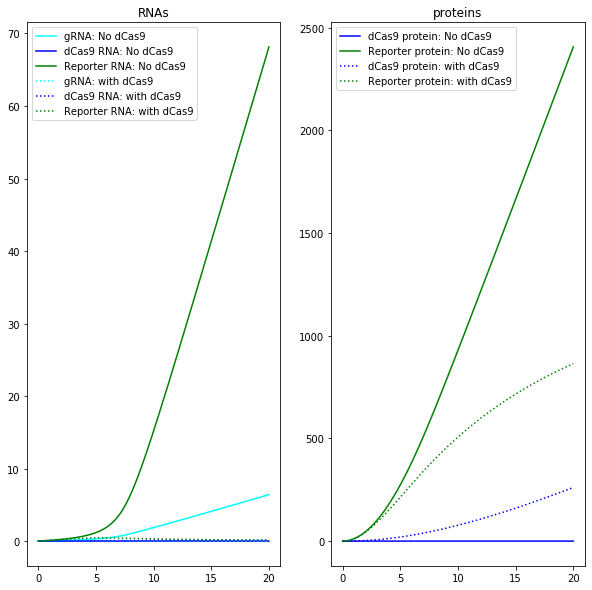

In [3]:
#Create some default parameters to be lazy. Most parameters will just use these
parameters = {
    "ktx":1.0, "ktl":3.0, "kdeg":.5, "kb":100, "ku":50, "cooperativity":1
}

# Create an assembly to express dCas9
dCas_assembly = DNAassembly("dCas9", promoter="P", rbs="BCD")
# Get the dCas Species. Note: This could also be defined above and passed into the assembly as protein=...
dCas = dCas_assembly.protein
# Create a Guide RNA Guide1
gRNA = bcp.guideRNA("gRNA", dCas=dCas)
# Create an assembly to express the guide RNA
gRNA_assembly = DNAassembly("gRNA", transcript=gRNA, promoter="P", rbs=None)

# Get the guideRNA:dCas9 complex
repressor = gRNA.get_dCasComplex()

# Create a Promoter regulated by the repressor
P_reg = RegulatedPromoter("P_regulated", regulators=[repressor], leak=True)
P_reg.default_mechanisms['binding'] = Reversible_Bimolecular_Binding("dCas9_dna_binding")
#Use the custom mechanism name to set the parameters for all dCas9_dna_binding
parameters[("dCas9_dna_binding", "ku")] = .01
parameters[("dCas9_dna_binding", "kb")] = 1000


#Set parameters of the repressed promoter
parameters[("transcription", P_reg.name+'_'+repressor.name, "ku")] = 1000
parameters[("transcription", P_reg.name+'_'+repressor.name, "ktx")] = .1
#Set Parameters of the unrepressed promoter
parameters[("transcription", P_reg.name, "ku")] = .1
parameters[("transcription", P_reg.name, "ktx")] = 2.0

# Create an assembly with the regulated promoter
reg_assembly = bcp.DNAassembly(name="reporter", promoter=P_reg, rbs="BCD")

# Create a list of components to add to the mixture (these could also be added one-by-one with Mixture.add_component(...)
components = [dCas_assembly, gRNA_assembly, gRNA, reg_assembly]

# Create a BasicExtract Mixture
reaction_mix = bcp.BasicExtract("txtl", components=components, parameters=parameters, parameter_warnings = False)

# Compile a CRN
CRN = reaction_mix.compile_crn()
print(repr(CRN))

print("Simulating with BioSCRAPE")

x0_no_dcas = {repr(dCas_assembly.get_species()):0, "dna_gRNA":1, repr(reg_assembly.dna):5, "protein_RNAP":10, "protein_RNAase":10, "protein_Ribo":50}
x0_with_dcas = {repr(dCas_assembly.get_species()):1, "dna_gRNA":1, repr(reg_assembly.dna):5, "protein_RNAP":10, "protein_RNAase":10, "protein_Ribo":50}


#Simulate with BioSCRAPE if installed
try:
    print("Simulating")
    import numpy as np
    import pylab as plt
    timepoints = np.arange(0, 20, .01)

    stochastic = False
    sim_no_cas = CRN.simulate_with_bioscrape(timepoints, x0_no_dcas, stochastic = stochastic)
    sim_with_cas = CRN.simulate_with_bioscrape(timepoints, x0_with_dcas, stochastic = stochastic)


    plt.figure(figsize = (10, 10))
    plt.subplot(121)
    plt.title("RNAs")
    plt.plot(timepoints, sim_no_cas["rna_gRNA"], color = "cyan", label = "gRNA: No dCas9")
    plt.plot(timepoints, sim_no_cas["rna_dCas9"], color = "blue", label = "dCas9 RNA: No dCas9")
    plt.plot(timepoints, sim_no_cas["rna_reporter"], color = "green", label = "Reporter RNA: No dCas9")

    plt.plot(timepoints, sim_with_cas["rna_gRNA"], ":", color = "cyan", label = "gRNA: with dCas9")
    plt.plot(timepoints, sim_with_cas["rna_dCas9"], ":", color = "blue", label = "dCas9 RNA: with dCas9")
    plt.plot(timepoints, sim_with_cas["rna_reporter"], ":", color = "green", label = "Reporter RNA: with dCas9")

    plt.legend()
    
    plt.subplot(122)
    plt.title("proteins")
    plt.plot(timepoints, sim_no_cas["protein_dCas9"], color = "blue", label = "dCas9 protein: No dCas9")
    plt.plot(timepoints, sim_no_cas["protein_reporter"], color = "green", label = "Reporter protein: No dCas9")

    plt.plot(timepoints, sim_with_cas["protein_dCas9"], ":", color = "blue", label = "dCas9 protein: with dCas9")
    plt.plot(timepoints, sim_with_cas["protein_reporter"], ":", color = "green", label = "Reporter protein: with dCas9")
    plt.legend()

    plt.plot()
    plt.legend()
    plt.show()
except ModuleNotFoundError:
    pass


## Dilution with Global Mechanisms
Global mechanisms provide a framework to have certain reactions work on all, or almost all, species in a CRN. They are to be used with caution: depending on the order global mechanisms are applied, different resulting CRNs are possible. In fact, the recommendation is to only use global mechanisms for degredation by dilution. In the following example, a model will be set up where global mechanisms cause degredation by dilution on all species which are not labeled as "genomic" or "machinery".

Under the hood, global mechanisms work just like normal mechanisms - they take a set of species and compile them into CRNs. Global mechanisms are called at the end of the compilation, so they apply to all species generated by all local mechanisms. In order to make global mechanisms more selective, a filter_dict keywork can be used. The filter_dict (str:True/False) takes some str such as "dna" or "genomic" which is either a specie type, name, or attribute. The mechanism is then applied or not based upon the value of that attribute in the filter_dict. For exampe filter_dict = {"dna":False} would not apply its mechanism to any "dna" species. For species with no attributes in the filter_dict, a global mechanism defaults to its default_on keyword, which can be True or False.

In the below example, we will show how filters and attributes work on constuitively expressed genes using dilution as the prototypical example. 

Species = protein_RNAP_machinery, protein_Ribo_machinery, protein_RNAase_machinery, protein_G1, complex_dna_G1_protein_RNAP_machinery, dna_G1, rna_G1, complex_rna_G1_protein_Ribo_machinery, complex_rna_G1_protein_RNAase_machinery, complex_dna_G2_protein_RNAP_machinery_genomic, protein_G2, rna_G2, complex_rna_G2_protein_Ribo_machinery, dna_G2_genomic, complex_rna_G2_protein_RNAase_machinery
Reactions = [
	dna_G1 + protein_RNAP_machinery <--> complex_dna_G1_protein_RNAP_machinery        massaction: k_f(dna_G1,protein_RNAP_machinery)=100*dna_G1*protein_RNAP_machinery        k_r(complex_dna_G1_protein_RNAP_machinery)=20*complex_dna_G1_protein_RNAP_machinery
	complex_dna_G1_protein_RNAP_machinery --> dna_G1 + rna_G1 + protein_RNAP_machinery        massaction: k_f(complex_dna_G1_protein_RNAP_machinery)=3*complex_dna_G1_protein_RNAP_machinery
	rna_G1 + protein_Ribo_machinery <--> complex_rna_G1_protein_Ribo_machinery        massaction: k_f(rna_G1,protein_Ribo_machinery)=100*rna_G1*protein_Rib

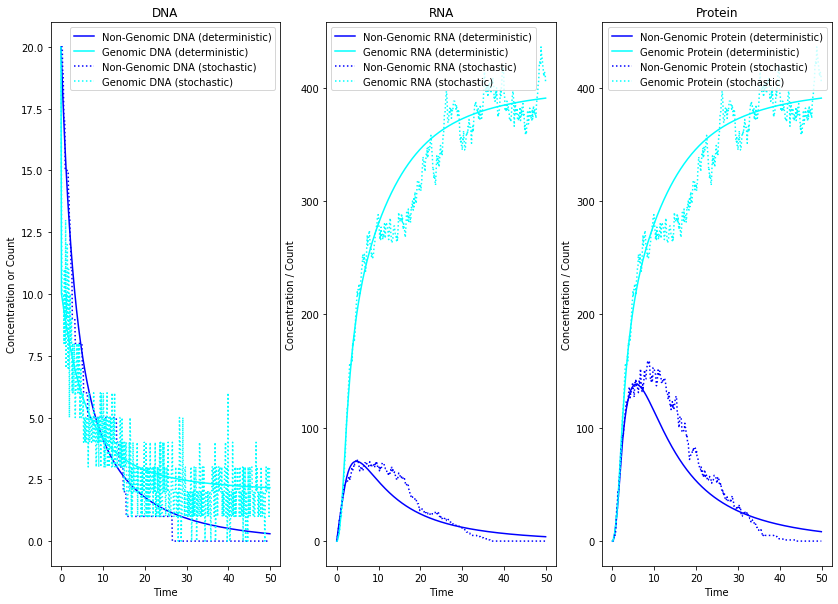

In [4]:
from biocrnpyler import *

#We will only use default parameters in this model, for simplicity.
kb, ku, ktx, ktl, kdeg, kdil = 100, 20, 3, 2, .5, .5
parameters = {"kb":kb, "ku":ku, "ktx":ktx, "ktl":ktl, "kdeg": kdeg, "kdil":kdil}

#Creates a global dilution mechanism that acts on all species generated except for
# those with the type or attribute "genome" or "machinery"
dilution_mechanism = Dilution(filter_dict = {"genomic":False, "machinery":False}, default_on = True)

#Add this mechanism to a dictionary which is passed into the Mixture txtl.BasicExtract
global_mechanisms = {"dilution":dilution_mechanism}
myMixture = BasicExtract(name = "txtl", parameters = parameters, global_mechanisms = global_mechanisms, parameter_warnings= False)

#Add machinery attributes to species I want constiutively expressed at the dilution rate
myMixture.rnap.add_attribute("machinery")
myMixture.rnaase.add_attribute("machinery")
myMixture.ribosome.add_attribute("machinery")

#Creates a dna assembly. This assembly is type "dna" so it will be degraded
A_dna = DNAassembly(name = "G1", promoter = "pBest", rbs = "BCD2")

#Create another dna assembly but set its internal specie's attributes to contain "genomic" so it will not be degraded
#Note: this only protects the dna_G2 species encoded by this assembly as well as complex species (eg rnap:DNA) which inherit their subspecies attributes.
A_genome = DNAassembly(name = "G2", promoter = "pBest", rbs = "BCD2", attributes = ["genomic"])


myMixture.add_components(A_dna)
myMixture.add_components(A_genome)
myCRN = myMixture.compile_crn()
print(repr(myCRN))


try:
    print("Simulating with BioSCRAPE")
    import numpy as np
    import pylab as plt
    timepoints = np.arange(0, 50, .1)

    x0_dict = {repr(myMixture.ribosome.get_species()):100, 
               repr(myMixture.rnap.get_species()):20, 
               repr(myMixture.rnaase.get_species()):10, 
               repr(A_dna.dna):20, 
               repr(A_genome.dna):20}

    full_result_sto = myCRN.simulate_with_bioscrape(timepoints, x0_dict, stochastic = True)
    full_result_det = myCRN.simulate_with_bioscrape(timepoints, x0_dict, stochastic = False)

    #chemical_reaction_network.get_all_species_containing is a useful shortcut to get lists of species
    tot_A_dna_det = np.sum(full_result_det[myCRN.get_all_species_containing(A_dna.dna, return_as_strings=True)], 1)
    tot_A_genome_det = np.sum(full_result_det[myCRN.get_all_species_containing(A_genome.dna, return_as_strings=True)], 1)
    tot_A_dna_sto = np.sum(full_result_sto[myCRN.get_all_species_containing(A_dna.dna, return_as_strings=True)], 1)
    tot_A_genome_sto = np.sum(full_result_sto[myCRN.get_all_species_containing(A_genome.dna, return_as_strings=True)], 1)

    tot_A_dna_rna_det = np.sum(full_result_det[myCRN.get_all_species_containing(A_dna.transcript, return_as_strings=True)], 1)
    tot_A_genome_rna_det = np.sum(full_result_det[myCRN.get_all_species_containing(A_genome.protein, return_as_strings=True)], 1)
    tot_A_dna__rna_sto = np.sum(full_result_sto[myCRN.get_all_species_containing(A_dna.transcript, return_as_strings=True)], 1)
    tot_A_genome_rna_sto = np.sum(full_result_sto[myCRN.get_all_species_containing(A_genome.protein, return_as_strings=True)], 1)


    plt.figure(figsize = (14, 10))
    plt.subplot(131)
    plt.plot(timepoints, tot_A_dna_det, color = "blue", label = "Non-Genomic DNA (deterministic)")
    plt.plot(timepoints, tot_A_genome_det, color = "cyan", label = "Genomic DNA (deterministic)")
    plt.plot(timepoints, tot_A_dna_sto, ":", color = "blue", label = "Non-Genomic DNA (stochastic)")
    plt.plot(timepoints, tot_A_genome_sto, ":", color = "cyan", label = "Genomic DNA (stochastic)")
    plt.legend()
    plt.xlabel("Time")
    plt.title("DNA")
    plt.ylabel("Concentration or Count")

    plt.subplot(132)
    plt.plot(timepoints, tot_A_dna_rna_det, color = "blue", label = "Non-Genomic RNA (deterministic)")
    plt.plot(timepoints, tot_A_genome_rna_det, color = "cyan", label = "Genomic RNA (deterministic)")
    plt.plot(timepoints, tot_A_dna__rna_sto, ":", color = "blue", label = "Non-Genomic RNA (stochastic)")
    plt.plot(timepoints, tot_A_genome_rna_sto, ":", color = "cyan", label = "Genomic RNA (stochastic)")
    plt.legend()
    plt.xlabel("Time")
    plt.title("RNA")
    plt.ylabel("Concentration / Count")

    plt.subplot(133)
    plt.plot(timepoints, full_result_det[str(A_dna.protein)], color = "blue", label = "Non-Genomic Protein (deterministic)")
    plt.plot(timepoints, full_result_det[str(A_genome.protein)], color = "cyan", label = "Genomic Protein (deterministic)")
    plt.plot(timepoints, full_result_sto[str(A_dna.protein)], ":", color = "blue", label = "Non-Genomic Protein (stochastic)")
    plt.plot(timepoints, full_result_sto[str(A_genome.protein)], ":", color = "cyan", label = "Genomic Protein (stochastic)")
    plt.legend()
    plt.title("Protein")
    plt.xlabel("Time")
    plt.ylabel("Concentration / Count")

    plt.show()
except ModuleNotFoundError:
    pass